We used a SBM with two blocks or clusters C1 and C2. Each cluster consists of 10000 nodes. A randomly chosen pair of nodes is connected by an edge with probability 1/5 (1/100) if they belong to the same block (different blocks). The cluster (21) delivered by nLasso (6), with α = 1/10 and λ = 2/sqrt(sum(weights)) and using 10% randomly chosen seed nodes, perfectly recovered the true clusters.

In [1]:
import numpy as np
import random
import math
import datetime

from stochastic_block_model import get_B_and_weight_vec
from sbm import SBM
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans, spectral_clustering, SpectralClustering
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

Let's compare our method with spectral clustering for more examples.
https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py

In [8]:
import random
import math
import itertools
import numpy as np
from sklearn.cluster import spectral_clustering, SpectralClustering
from sklearn.metrics.cluster import normalized_mutual_info_score
from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans
import datetime
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture

import warnings
warnings.filterwarnings('ignore')

n_samples = 6000

def accuracy(labels, true_labels):
    total_common = 0
    cluster_names = set(true_labels)
    permutations = list(itertools.permutations(cluster_names))
    for permutation in permutations:
        max_common = 0
        for i, cluster_name in enumerate(cluster_names):
            cluster_nodes = np.where(labels == cluster_name)[0]
            cluster_name1 = permutation[i]
            true_nodes = np.where(true_labels == cluster_name1)[0]

            common = len(set(true_nodes) - (set(true_nodes) - set(cluster_nodes)))
            max_common += common

        total_common = max(total_common, max_common)

    return total_common / len(true_labels)

def get_B_and_weight_vec_ring(points, threshhold=0.2):
    N = len(points)
    clustering = SpectralClustering(n_clusters=2, assign_labels="discretize", random_state=0).fit(points)
    A = clustering.affinity_matrix_

    row = []
    col = []
    data = []
    weight_vec = []
    cnt = 0
    for i in range(N):
        for j in range(N):
            if j <= i:
                continue
            if A[i, j] < threshhold:
                A[i, j] = 0
                A[j, i] = 0
                continue
            row.append(cnt)
            col.append(i)
            data.append(1)

            row.append(cnt)
            col.append(j)
            data.append(-1)
            cnt += 1
            weight_vec.append(A[i, j])

    B = csr_matrix((data, (row, col)), shape=(cnt, N))
    weight_vec = np.array(weight_vec)
    return A, B, weight_vec

def generate_seeds(A, B, N, proportion=0.1):
#use unweighted A and its square to explore a local neighborhood of our initial node
    def filter_seeds(initial_seed):
        i=0
        while True:
            #b is a set of nodes with more common neighbors with the initial seed according to a threshold i
            b = set(np.where(S[initial_seed]>i)[0])  
#             print('b',b)
            samplingset=list(a.intersection(b))
#             print(samplingset)
            if len(samplingset)<5:   
                break
            elif len(samplingset)>N*proportion:   
                i+=1
            else :
                break
        
        samplingset += [initial_seed]
        return samplingset
    
    #squared A
    unweighted_A = (A>0).astype(int)-np.eye(A.shape[0],A.shape[1]) 
    S = np.dot(unweighted_A,unweighted_A)
    degrees = np.asarray(np.sum(abs(B),0))[0]
    initial_seeds = np.random.choice(np.where(degrees>12)[0],6,replace=False)
    print('initial_seeds',initial_seeds)
    samplingsets = []
    for s in initial_seeds:
        a = set(np.where(unweighted_A[s]>0)[0])  #include all the neighbors as candidate seeds
        samplingsets.append(filter_seeds(s))
    
    return samplingsets


def run_more_plots(points, true_labels, K, alpha, lambda_nLasso, threshhold, n_clusters, M=0.2, plot=False, is_print=True):
    A, B, weight_vec = get_B_and_weight_vec_ring(points, threshhold=threshhold)

#     print("lambda", n_clusters**3 / (np.sum(weight_vec))**(1/n_clusters))
    E, N = B.shape

    samplingsets = generate_seeds(A, B, N, 0.1)
    Gamma_vec = np.array(1. / (np.sum(abs(B), 0)))[0]  # \in [0, 1]
    Gamma = np.diag(Gamma_vec)

    Sigma = 0.5

    fac_alpha = 1. / (Gamma_vec * alpha + 1)  # \in [0, 1]
    lambda_weight = lambda_nLasso * weight_vec

    our_labels = np.full(N, n_clusters-1)
    our_time = datetime.datetime.now() - datetime.datetime.now()
    signatures = []
    for samplingset in samplingsets:

        seednodesindicator = np.zeros(N)
        seednodesindicator[samplingset] = 1
        noseednodeindicator = np.ones(N)
        noseednodeindicator[samplingset] = 0


        hatx = np.zeros(N)
        newx = np.zeros(N)
        prevx = np.zeros(N)
        haty = np.array([x / (E - 1) for x in range(0, E)])
        gamma_plus = 1 + Gamma_vec[samplingset]
        start = datetime.datetime.now()
        for iterk in range(K):
            tildex = 2 * hatx - prevx
            newy = haty + Sigma * B.dot(tildex)  # chould be negative
            res = abs(newy) / lambda_weight
            res[res < 1] = 1
            haty = newy / res

            newx = hatx - Gamma_vec * B.T.dot(haty)  # could  be negative

            newx[samplingset] = (newx[samplingset] + Gamma_vec[samplingset]) / gamma_plus

            newx = seednodesindicator * newx + noseednodeindicator * (newx * fac_alpha)
            prevx = np.copy(hatx)
            hatx = newx  # could be negative
        our_time += datetime.datetime.now() - start
        X = newx
        X = np.nan_to_num(X, 0)
        signatures.append(X)

    signatures = np.array(signatures).T
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, algorithm='full').fit(signatures)
    our_labels = kmeans.labels_

    our_accuracy = accuracy(our_labels, true_labels)
    our_nmi = normalized_mutual_info_score(our_labels, true_labels)
    if is_print:
        print ('our time is:', our_time)
        print ('our accuracy is:', our_accuracy)
        print ('our nmi is:', our_nmi)
    
    if plot:
        print('our method clusters')
        for label_name in list(set(our_labels)):
            plt.scatter(points[np.where(our_labels == label_name)[0]][:, 0], points[np.where(our_labels == label_name)[0]][:, 1], label='0')

        plt.show()
        plt.close()
    
    
    start = datetime.datetime.now()
    labels = spectral_clustering(A, n_clusters=n_clusters)
    spectral_time = datetime.datetime.now() - start
    spectral_accuracy = accuracy(labels, true_labels)
    spectral_nmi = normalized_mutual_info_score(labels, true_labels)
    if is_print:
        print ('spectral clustering time is:', spectral_time)
        print ('spectral clustering accuracy is:', spectral_accuracy)
        print ('spectral clustering nmi is:', spectral_nmi)

    
    if plot:
        print('spectral clustering clusters')
        for label_name in list(set(labels)):
            plt.scatter(points[np.where(labels == label_name)[0]][:, 0], points[np.where(labels == label_name)[0]][:, 1], label='0')

        plt.show()
        plt.close()
    
        print('true clusters')
        for label_name in list(set(labels)):
            plt.scatter(points[np.where(true_labels == label_name)[0]][:, 0], points[np.where(true_labels == label_name)[0]][:, 1], label='0')

        plt.show()
        plt.close()
    return our_accuracy, our_nmi, our_time, spectral_accuracy, spectral_nmi, spectral_time
 

In [22]:
def run_noisy_circles(alpha, lambda_lasso, plot=False, is_print=True):
    noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.3, noise=.05) 

    points = noisy_circles[0] * 2
    true_labels = noisy_circles[1]

    return run_more_plots(points, true_labels, 60, alpha, lambda_lasso, 0.3, 2, plot=plot, is_print=is_print)



initial_seeds [2368 5696 1139 3409 1708 1469]
our time is: 0:00:34.351403
our accuracy is: 1.0
our nmi is: 1.0
our method clusters


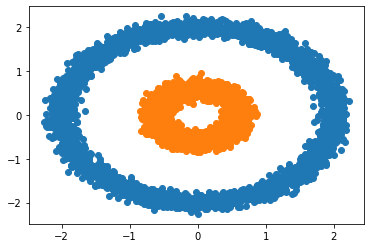

spectral clustering time is: 0:00:03.926966
spectral clustering accuracy is: 1.0
spectral clustering nmi is: 1.0
spectral clustering clusters


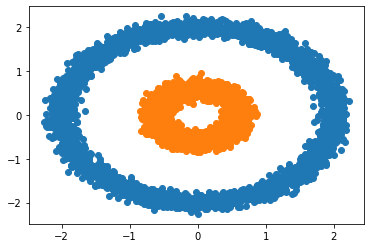

true clusters


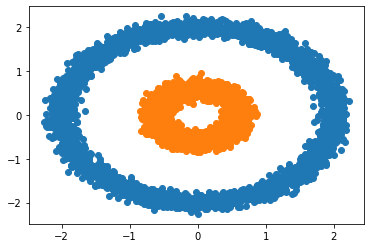

(1.0,
 1.0,
 datetime.timedelta(seconds=34, microseconds=351403),
 1.0,
 1.0,
 datetime.timedelta(seconds=3, microseconds=926966))

In [23]:
run_noisy_circles(0.1, 0.4, True)   

In [24]:
def run_noisy_moons(alpha, lambda_lasso, plot=False, is_print=True):
    noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)

    points = noisy_moons[0] * 3
    true_labels = noisy_moons[1]
    

    return run_more_plots(points, true_labels, 60, alpha, lambda_lasso, 0.3, 2, plot=plot, is_print=is_print)


initial_seeds [4130 2146 3221 5152 2285 4835]
our time is: 0:00:15.016534
our accuracy is: 1.0
our nmi is: 1.0
our method clusters


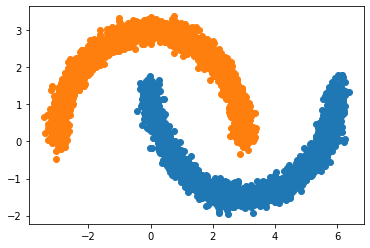

spectral clustering time is: 0:00:05.563067
spectral clustering accuracy is: 1.0
spectral clustering nmi is: 1.0
spectral clustering clusters


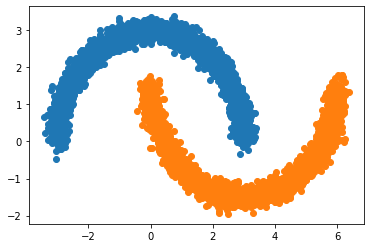

true clusters


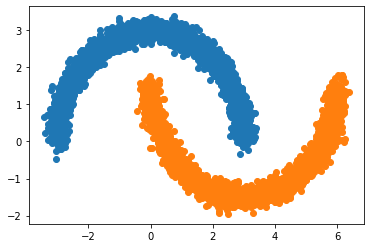

(1.0,
 1.0,
 datetime.timedelta(seconds=15, microseconds=16534),
 1.0,
 1.0,
 datetime.timedelta(seconds=5, microseconds=563067))

In [25]:
run_noisy_moons(0.1, 0.4, True) 

In [26]:
def run_blobs(alpha, lambda_lasso, plot=False, is_print=True):
    blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)

    points = blobs[0] 
    true_labels = blobs[1]

    return run_more_plots(points, true_labels, 60, alpha, lambda_lasso, 0.009, 3, plot=plot, is_print=is_print)
    

initial_seeds [1898 1397 5141  614  263 1862]
our time is: 0:00:33.023600
our accuracy is: 1.0
our nmi is: 1.0
our method clusters


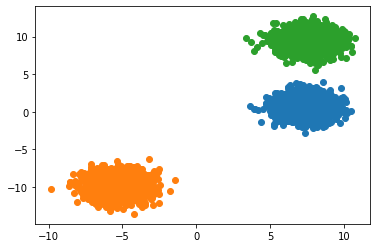

spectral clustering time is: 0:00:05.377600
spectral clustering accuracy is: 1.0
spectral clustering nmi is: 1.0
spectral clustering clusters


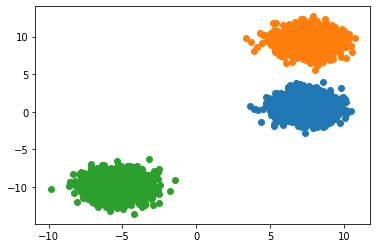

true clusters


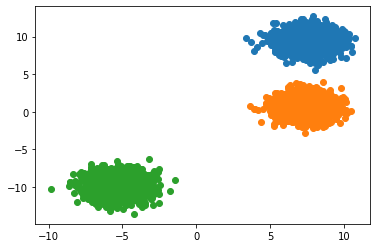

(1.0,
 1.0,
 datetime.timedelta(seconds=33, microseconds=23600),
 1.0,
 1.0,
 datetime.timedelta(seconds=5, microseconds=377600))

In [27]:
run_blobs(0.1, 0.5, True) 

In [30]:
def run_varied(alpha, lambda_lasso, plot=False, is_print=True):
    random_state = 170
    varied = datasets.make_blobs(n_samples=n_samples,
                                 cluster_std=[1.0, 2.5, 0.5],
                                 random_state=random_state)

    points = varied[0] 
    true_labels = varied[1]

    return run_more_plots(points, true_labels, 30, alpha, lambda_lasso, 0.5, 3, plot=plot, is_print=is_print)

initial_seeds [4805   99 1373 1120  185 4076]
our time is: 0:00:05.245520
our accuracy is: 0.9686666666666667
our nmi is: 0.887109802409325
our method clusters


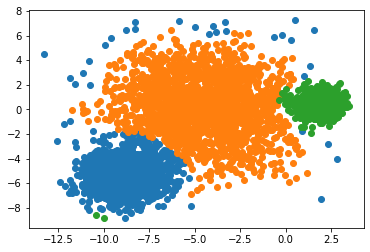

spectral clustering time is: 0:00:11.226834
spectral clustering accuracy is: 0.335
spectral clustering nmi is: 0.003952159078362658
spectral clustering clusters


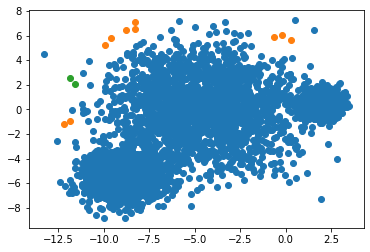

true clusters


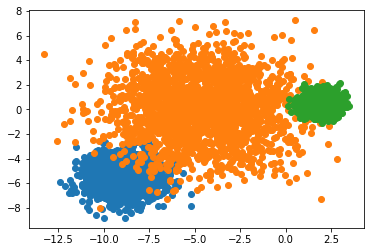

(0.9686666666666667,
 0.887109802409325,
 datetime.timedelta(seconds=5, microseconds=245520),
 0.335,
 0.003952159078362658,
 datetime.timedelta(seconds=11, microseconds=226834))

In [31]:
run_varied(0.5, 0.3, True)

In [32]:
def run_aniso(alpha, lambda_lasso, plot=False, is_print=True):
    random_state = 170
    X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
    transformation = [[0.6, -0.6], [-0.4, 0.8]]
    X_aniso = np.dot(X, transformation)
    aniso = (X_aniso, y)

    points = aniso[0] 
    true_labels = aniso[1]

    return run_more_plots(points, true_labels, 50, alpha, lambda_lasso, 0.7, 3, plot=plot, is_print=is_print)


initial_seeds [5479  678  532 2865 1825 3318]
our time is: 0:00:09.858726
our accuracy is: 0.9971666666666666
our nmi is: 0.9821657158157394
our method clusters


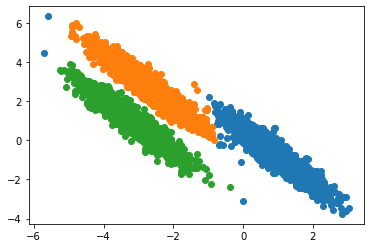

spectral clustering time is: 0:00:05.876734
spectral clustering accuracy is: 0.9971666666666666
spectral clustering nmi is: 0.9821657930025113
spectral clustering clusters


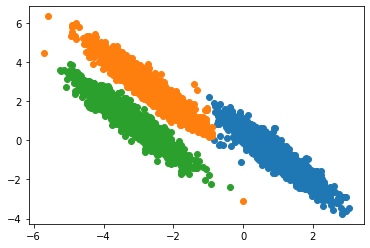

true clusters


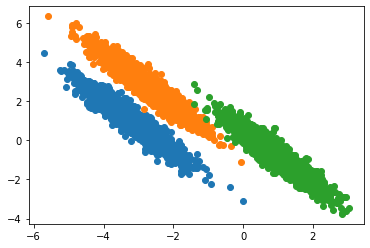

(0.9971666666666666,
 0.9821657158157394,
 datetime.timedelta(seconds=9, microseconds=858726),
 0.9971666666666666,
 0.9821657930025113,
 datetime.timedelta(seconds=5, microseconds=876734))

In [33]:
run_aniso(1.0, 0.5, True) 